## Topic Modeling with Latent Dirichlet Allocation

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from pathlib import Path
import os
import glob

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.io.json import json_normalize
import json

import pprint
import string

import matplotlib.pyplot as plt
import seaborn as sns

import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk('C:/Users/trivikram.cheedella/OneDrive - JD Power/Data Science Data/CORD-19-research-challenge'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# for filename in fnmatch.filter(filenames, '*.txt'):
# Any results you write to the current directory are saved as output.

In [2]:
input = Path('C:/Users/trivikram.cheedella/OneDrive - JD Power/Data Science Data/CORD-19-research-challenge')
output = Path('C:/Users/trivikram.cheedella/OneDrive - JD Power/Data Science Data/CORD-19-research-challenge/output')

noncomm_use_subset = Path('C:/Users/trivikram.cheedella/OneDrive - JD Power/Data Science Data/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset')


## Load the meta data file

In [3]:
df_all_sources_metadata = pd.read_csv(input / 'metadata.csv')

In [4]:
print(df_all_sources_metadata.shape)
df_all_sources_metadata.info()

(45774, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45774 entries, 0 to 45773
Data columns (total 17 columns):
cord_uid                       45774 non-null object
sha                            31753 non-null object
source_x                       45774 non-null object
title                          45617 non-null object
doi                            42440 non-null object
pmcid                          26243 non-null object
pubmed_id                      34641 non-null float64
license                        45774 non-null object
abstract                       37913 non-null object
publish_time                   45765 non-null object
authors                        43774 non-null object
journal                        41707 non-null object
Microsoft Academic Paper ID    964 non-null float64
WHO #Covidence                 1768 non-null object
has_full_text                  45774 non-null bool
full_text_file                 35558 non-null object
url                            454

In [5]:
df_all_sources_metadata.head(3)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866


In [6]:
pd.pivot_table(df_all_sources_metadata, index='full_text_file', values=['sha', 'source_x', 'has_full_text'], aggfunc={'sha': 'count', 'source_x': 'count', 'has_full_text': np.sum}, margins=True)

,has_full_text,sha,source_x
full_text_file,,,
biorxiv_medrxiv,1053.0,1053,1218
comm_use_subset,8864.0,8864,8982
custom_license,19816.0,19816,23227
noncomm_use_subset,2020.0,2020,2131
All,31753.0,31753,31753


## ReadIn the JSON Files

The following code for reading in the JSON file is taken from the notebook <b>COVID EDA: Initial Exploration Tool</b> by <i><b>Ivan Ega Pratama</b></i>

https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool

In [7]:
%%time
all_json = glob.glob(f'{noncomm_use_subset}/**/*.json', recursive=True)
len(all_json)

Wall time: 54.9 ms


2350

In [8]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
            # Extend Here
            #
            #
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

0036b28fddf7e93da0970303672934ea2f9944e7: and Blautia (P = 0.008) significantly decreased on day 20 and C. hiranonis (p = 0.001) on day 60. Blautia (P = 0.017) remained decreased on day 60. E.coli remained unchanged on day 20 (P = 0.999) but ... human type 1 DM. The aim of this study was to evaluate changes in fecal microbiota and fecal unconjugated BAs profile in dogs with naturally-occurring DM during insulin therapy and compare them to hea...


In [9]:
%%time
dict_ = {'paper_id': [], 'abstract': [], 'body_text': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text'])
df_covid.head()

Processing index: 0 of 2350
Processing index: 235 of 2350
Processing index: 470 of 2350
Processing index: 705 of 2350
Processing index: 940 of 2350
Processing index: 1175 of 2350
Processing index: 1410 of 2350
Processing index: 1645 of 2350
Processing index: 1880 of 2350
Processing index: 2115 of 2350
Wall time: 10.9 s


,paper_id,abstract,body_text
0,0036b28fddf7e93da0970303672934ea2f9944e7,and Blautia (P = 0.008) significantly decrease...,human type 1 DM. The aim of this study was to ...
1,005c43980edf3fcc2a4d12ee7ad630ddb651ce6e,Accurate and rapid diagnosis of highly pathoge...,Avian influenza (AI) viruses are distinct from...
2,00676f1131e03ca8defe523e79bc1635cc933909,A high percentage (up to 90%) of dromedary cam...,Dromedary camels (Camelus dromedarius) appear ...
3,006be99e337c84b8758591a54f0362353b24dfde,"253 protein, C-reactive protein (CRPt), varies...",Abstract. The half-time for secretion of the p...
4,00a00d0edc750db4a0c299dd1ec0c6871f5a4f24,,This is an Open Access article distributed und...


In [10]:
dict_ = None

In [11]:
%%time
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))
df_covid.head()

Wall time: 1.95 s


,paper_id,abstract,body_text,abstract_word_count,body_word_count
0,0036b28fddf7e93da0970303672934ea2f9944e7,and Blautia (P = 0.008) significantly decrease...,human type 1 DM. The aim of this study was to ...,2805,45487
1,005c43980edf3fcc2a4d12ee7ad630ddb651ce6e,Accurate and rapid diagnosis of highly pathoge...,Avian influenza (AI) viruses are distinct from...,171,7422
2,00676f1131e03ca8defe523e79bc1635cc933909,A high percentage (up to 90%) of dromedary cam...,Dromedary camels (Camelus dromedarius) appear ...,74,1283
3,006be99e337c84b8758591a54f0362353b24dfde,"253 protein, C-reactive protein (CRPt), varies...",Abstract. The half-time for secretion of the p...,415,8551
4,00a00d0edc750db4a0c299dd1ec0c6871f5a4f24,,This is an Open Access article distributed und...,0,1039


In [12]:
df_covid.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
paper_id,2350,2350,01de46a248049d2fbdc049b686ee5b172301d0fa,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abstract,2350,1573,,646,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body_text,2350,2215,The ongoing epidemic of the novel coronavirus ...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abstract_word_count,2350,NaN,NaN,NaN,153.529,144.924,0,0,157,234.75,2805
body_word_count,2350,NaN,NaN,NaN,4139.94,7583.47,1,1990.25,3127,4983,241076


In [13]:
df_covid.drop_duplicates(['body_text'], inplace=True)
df_covid.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
paper_id,2215,2215,01de46a248049d2fbdc049b686ee5b172301d0fa,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abstract,2215,1569,,624,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body_text,2215,2215,H ealth care-associated infections are one of ...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abstract_word_count,2215,NaN,NaN,NaN,152.363,146.373,0,0,156,234,2805
body_word_count,2215,NaN,NaN,NaN,4198.11,7795.98,1,2001,3137,5028,241076


## Clean up the text

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS

In [15]:
lemmatizer = WordNetLemmatizer()

print("Number of stopwrods from STOPWORDS: ", len(STOPWORDS))
print("Number of stopwrods from stopwords.words('english'): ", len(stopwords.words('english')))
other_stopwords = ['q', 'license', 'preprint', 'copyright', 'http', 'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.', 'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da',  'dell',  'non', 'si', 'cc']
custom_stopwords = []
custom_stopwords = list(set(stopwords.words('english') + list(STOPWORDS))) + other_stopwords

print("Number of stopwrods from custom_stopwords: ", len(custom_stopwords))
print(custom_stopwords[-25:])

Number of stopwrods from STOPWORDS:  190
Number of stopwrods from stopwords.words('english'):  179
Number of stopwrods from custom_stopwords:  264
['author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.', 'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da', 'dell', 'non', 'si', 'cc']


In [16]:
def clean_the_text(text):
        text = re.sub('[^a-zA-Z0-9-]', ' ', text)
        tokens = word_tokenize(text)
        # remove_punc = [word for word in tokens if word not in string.punctuation]
        remove_stopwords = [word.lower() for word in tokens if word.lower() not in custom_stopwords]
        more_than_three = [w for w in remove_stopwords if len(w)>3]
        lem = [lemmatizer.lemmatize(w) for w in more_than_three]
        return ' '.join(lem)

# cleaned_text = clean_the_text("my name is TRIVIKRAM, and I am first born in my fam don't process processing patients")
# print(cleaned_text)

In [17]:
df_covid_for_nlp = df_covid.copy()
df_covid = None

In [18]:
%%time
df_covid_for_nlp['cleaned_text'] = df_covid_for_nlp['body_text'].apply(lambda x: clean_the_text(x))

Wall time: 3min 54s


In [19]:
df_covid_for_nlp['cleaned_text'].head()

0    human type study evaluate change fecal microbi...
1    avian influenza virus distinct human seasonal ...
2    dromedary camel camelus dromedarius appear pla...
3    abstract half-time secretion plasma protein c-...
4    open access article distributed term creative ...
Name: cleaned_text, dtype: object

In [ ]:
# placeholder cell to sub-set data
# df_covid_for_nlp_10K = df_covid_for_nlp.head(10000).copy()
# df_covid_for_nlp_10K.shape

# Topic Modeling using Latent Dirichlet Allocation (LDA)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

### Convert the text data to Term frequency - Inverse Document frequency

In [21]:
%%time 

tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix_Tfidf = tfidf_vect.fit_transform(df_covid_for_nlp['cleaned_text'].values.astype('U'))

Wall time: 1min 27s


In [22]:
doc_term_matrix_Tfidf

<2215x47217 sparse matrix of type '<class 'numpy.float64'>'
	with 1518379 stored elements in Compressed Sparse Row format>

### Use GridSearchCV to find the best parameters for LDA

In [23]:
%%time
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30, 50], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
grid_search_model = GridSearchCV(lda, param_grid=search_params, n_jobs=-1)

# Do the Grid Search
grid_search_model.fit(doc_term_matrix_Tfidf)

Wall time: 26min 3s


GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [24]:
# Best Model
best_lda_model = grid_search_model.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid_search_model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", grid_search_model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_term_matrix_Tfidf))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -77387.80875970286
Model Perplexity:  63822.54778236966


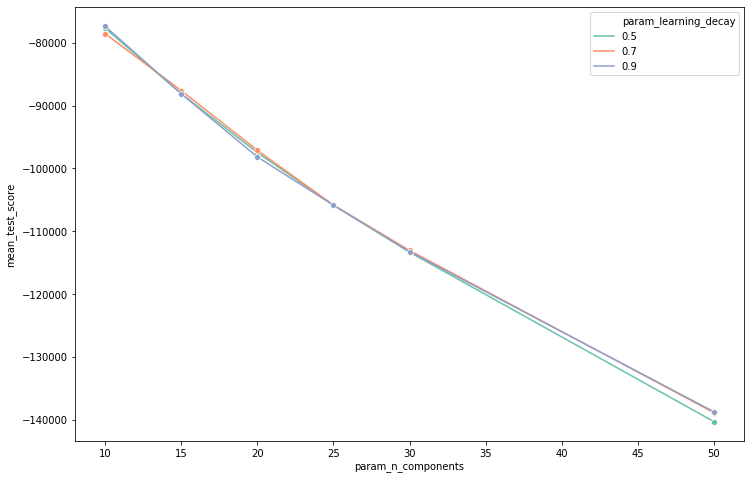

In [25]:
df_results = pd.DataFrame(grid_search_model.cv_results_)

current_palette = sns.color_palette("Set2", 3)

plt.figure(figsize=(12,8))

sns.lineplot(data=df_results,
             x='param_n_components',
             y='mean_test_score',
             hue='param_learning_decay',
             palette=current_palette,
             marker='o')

plt.show()

### Getting 10 random features

In [26]:
import random

for i in range(10):
    random_id = random.randint(0,len(tfidf_vect.get_feature_names()))
    print(tfidf_vect.get_feature_names()[random_id])

smacking
augments
customize
refractometry
igg2b
limping
belonging
nagashima
plutner
aflli


### Print the top 10 words from the first topic

In [27]:
first_topic = best_lda_model.components_[0]

In [28]:
top_topic_words = first_topic.argsort()[-10:]
top_topic_words

array([44084, 11564, 19565, 35670, 13795, 21850, 19615, 33260, 31790,
       15303], dtype=int64)

In [29]:
for i in top_topic_words:
    print(tfidf_vect.get_feature_names()[i])

trim21
ctps
h57y
pvp
ditchfield
iltv
had5
pi4kb
pams
endu


### Print the top 10 words topic wise

In [30]:
for i,topic in enumerate(best_lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['trim21', 'ctps', 'h57y', 'pvp', 'ditchfield', 'iltv', 'had5', 'pi4kb', 'pams', 'endu']


Top 10 words for topic #1:
['cahv', 'meth', 'sstr2', 'paraquat', 'hfnc', 'lamc2', 'palmitoylation', 'csos', 'cirdc', 'malat1']


Top 10 words for topic #2:
['a2ntd', 'lesional', 'hnpc', 'oa', 'st', 'telemedicine', 'medi8852', 'hnpcs', 'afop', 'adem']


Top 10 words for topic #3:
['meld', 'sirt7', 'fortaleza', 'niv', 'hpev', 'curitiba', 'ggos', 'ddx1', 'ginseng', 'hms']


Top 10 words for topic #4:
['akap7', 'hafr', 'sias', 'xylitol', 'usp9x', 'plts', 'batin', 'haemolytica', 'm8c4', 'fvm09']


Top 10 words for topic #5:
['akata', 'durc', 'fibrillarin', 'cxcr3', 'nirvs', 'mcis', 'task', 'amphob', 'hpiv4', 'imha']


Top 10 words for topic #6:
['syllabus', 'sesamoid', 'geniunc', 'espb', 'neurona', 'alp', 'mtb', 'bsaas', 'tdcs', 'dpap']


Top 10 words for topic #7:
['amph', 'osbp', 'c3ar', 'cakv', 'jhmv', 'cap0', 'pdmp', 'nvp018', 'aiii', 'mastv5']


Top 10 words for topic #

### Find the most dominant topic in each document

In [31]:
topic_values_tfidf = best_lda_model.transform(doc_term_matrix_Tfidf)
topic_values_tfidf.shape

(2215, 10)

In [32]:
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

rows = df_covid_for_nlp['paper_id']

In [33]:
df_topic_values_tfidf = pd.DataFrame(topic_values_tfidf, columns=topicnames, index=rows)

In [34]:
df_topic_values_tfidf['topic_number_tfidf'] = topic_values_tfidf.argmax(axis=1)

In [35]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [36]:
df_topic_values_tfidf.head(10).style.applymap(color_green).applymap(make_bold)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,topic_number_tfidf
paper_id,,,,,,,,,,,
0036b28fddf7e93da0970303672934ea2f9944e7,0.00461836,0.0046213,0.00462131,0.0046172,0.00461736,0.00462239,0.00461822,0.00462564,0.958421,0.00461707,8
005c43980edf3fcc2a4d12ee7ad630ddb651ce6e,0.00633073,0.00633073,0.00633073,0.00633269,0.00633074,0.00633073,0.00633073,0.0669176,0.882435,0.00633073,8
00676f1131e03ca8defe523e79bc1635cc933909,0.00977026,0.00977026,0.00977026,0.00977026,0.00977026,0.00977026,0.00977026,0.00977026,0.912068,0.00977026,8
006be99e337c84b8758591a54f0362353b24dfde,0.00608315,0.00608315,0.00608315,0.00608315,0.00608315,0.00608315,0.00608315,0.00608315,0.945252,0.00608315,8
00a00d0edc750db4a0c299dd1ec0c6871f5a4f24,0.00618793,0.00618793,0.00618793,0.00618793,0.00618793,0.00618794,0.00618793,0.00618793,0.944309,0.00618793,8
00d4ff0cfe5582b3f2746b2a33d67f6bd4307e98,0.00766364,0.00767051,0.00766364,0.00766364,0.00766916,0.00766364,0.00766364,0.00766363,0.931015,0.00766364,8
00e5a723d44eb9f2698c38b518eff85c00f9753b,0.00744146,0.00744146,0.00744146,0.00744146,0.00744146,0.00744146,0.00744146,0.00744146,0.933027,0.00744146,8
01297dffaf94c1314ca46088f7b829b8383c2f73,0.00904983,0.00904983,0.00904983,0.00904983,0.00904983,0.00904983,0.00904983,0.00904983,0.918552,0.00904983,8
0134717f1b5ea99fc7e5ac305d492f5cedc8cd92,0.00646574,0.00646574,0.00646574,0.00646574,0.00646574,0.00646744,0.00646574,0.00646576,0.941807,0.00646574,8


### Create a dataframe for the 10 topics

In [37]:
dict_topic = {'topic_number_tfidf': [], 'topic_words_tfidf': []}

for i,topic in enumerate(best_lda_model.components_):
    dict_topic['topic_number_tfidf'].append(i)
    dict_topic['topic_words_tfidf'].append([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])

df_covid_topics_tfidf = pd.DataFrame(dict_topic, columns=['topic_number_tfidf', 'topic_words_tfidf'])
df_covid_topics_tfidf.head(10)

,topic_number_tfidf,topic_words_tfidf
0,0,"[trim21, ctps, h57y, pvp, ditchfield, iltv, ha..."
1,1,"[cahv, meth, sstr2, paraquat, hfnc, lamc2, pal..."
2,2,"[a2ntd, lesional, hnpc, oa, st, telemedicine, ..."
3,3,"[meld, sirt7, fortaleza, niv, hpev, curitiba, ..."
4,4,"[akap7, hafr, sias, xylitol, usp9x, plts, bati..."
5,5,"[akata, durc, fibrillarin, cxcr3, nirvs, mcis,..."
6,6,"[syllabus, sesamoid, geniunc, espb, neurona, a..."
7,7,"[amph, osbp, c3ar, cakv, jhmv, cap0, pdmp, nvp..."
8,8,"[health, disease, case, cov, mers, protein, in..."
9,9,"[ifnl4, vpk, stec, pi4p, syngeneic, trim5, raa..."


## Visualization using pyLDAvis

The visualization is a learning from the following source

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [38]:
import pyLDAvis
import pyLDAvis.sklearn

In [49]:
%%time

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, doc_term_matrix_Tfidf, tfidf_vect, mds='tsne', sort_topics=False)
panel

C:\Users\trivikram.cheedella\MyInstalledSoftware\Continuum\miniconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Wall time: 33min 6s


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1   0.891789
1       0.648955  71.707100       2        1   0.907527
2      71.019684   9.971006       3        1   0.921205
3       3.785981  33.185135       4        1   0.932091
4     -42.666500  -9.222070       5        1   0.947552
5      -3.621689 -43.526516       6        1   0.974807
6      -3.632402  -4.171708       7        1   1.013770
7     -36.584400  35.804413       8        1   1.249725
8      44.391380  50.615383       9        1  91.225874
9      40.235809 -31.591665      10        1   0.935659, topic_info=      Category      Freq         Term     Total  loglift  logprob
42461  Default  2.000000         task  2.000000  30.0000  30.0000
11175  Default  3.000000     coverage  3.000000  29.0000  29.0000
1093   Default  4.000000         2018  4.000000  28.0000  28.0000
42184  Default  4.000000  synthesized  4.000000  27.0000  27.0000
13746  Default  4.000000     distinct  4.000000  26.0000  26.0000
...        ...       ...          ...       ...      ...      ...
32137  Topic10  0.033428         pat1  0.187730   2.9461  -8.9269
8843   Topic10  0.041310  chaffeensis  0.247855   2.8799  -8.7152
35608  Topic10  0.045825    purifying  0.465767   2.3528  -8.6115
24412  Topic10  0.037550         knot  0.378596   2.3609  -8.8106
3478   Topic10  0.039695          air  1.064840   1.3823  -8.7551

[375 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
1033       9  0.921973         2004
1093       9  0.911845         2018
1462       9  1.038579           32
2504       9  0.911710  abnormality
2601       9  1.321216           ac
...      ...       ...          ...
42461      9  1.028171         task
43981      9  1.004153    treatment
45485      9  0.988645      vaccine
45974      9  1.001318        viral
46030      9  0.997363        virus

[66 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

### Merge the Topic numbers and top 10 words of each topic to the Meta Data for further analysis

In [40]:
df_covid_for_nlp['topic_number_tfidf'] = topic_values_tfidf.argmax(axis=1)

In [41]:
df_covid_for_nlp.head(3)

,paper_id,abstract,body_text,abstract_word_count,body_word_count,cleaned_text,topic_number_tfidf
0,0036b28fddf7e93da0970303672934ea2f9944e7,and Blautia (P = 0.008) significantly decrease...,human type 1 DM. The aim of this study was to ...,2805,45487,human type study evaluate change fecal microbi...,8
1,005c43980edf3fcc2a4d12ee7ad630ddb651ce6e,Accurate and rapid diagnosis of highly pathoge...,Avian influenza (AI) viruses are distinct from...,171,7422,avian influenza virus distinct human seasonal ...,8
2,00676f1131e03ca8defe523e79bc1635cc933909,A high percentage (up to 90%) of dromedary cam...,Dromedary camels (Camelus dromedarius) appear ...,74,1283,dromedary camel camelus dromedarius appear pla...,8


In [42]:
df_covid_for_nlp['topic_number_tfidf'].value_counts()

8    2198
7       5
5       4
0       3
1       2
9       1
4       1
2       1
Name: topic_number_tfidf, dtype: int64

In [43]:
df_covid_for_nlp = df_covid_for_nlp.merge(df_covid_topics_tfidf, how='left', left_on='topic_number_tfidf', right_on='topic_number_tfidf')

In [44]:
df_covid_for_nlp.head(3)

,paper_id,abstract,body_text,abstract_word_count,body_word_count,cleaned_text,topic_number_tfidf,topic_words_tfidf
0,0036b28fddf7e93da0970303672934ea2f9944e7,and Blautia (P = 0.008) significantly decrease...,human type 1 DM. The aim of this study was to ...,2805,45487,human type study evaluate change fecal microbi...,8,"[health, disease, case, cov, mers, protein, in..."
1,005c43980edf3fcc2a4d12ee7ad630ddb651ce6e,Accurate and rapid diagnosis of highly pathoge...,Avian influenza (AI) viruses are distinct from...,171,7422,avian influenza virus distinct human seasonal ...,8,"[health, disease, case, cov, mers, protein, in..."
2,00676f1131e03ca8defe523e79bc1635cc933909,A high percentage (up to 90%) of dromedary cam...,Dromedary camels (Camelus dromedarius) appear ...,74,1283,dromedary camel camelus dromedarius appear pla...,8,"[health, disease, case, cov, mers, protein, in..."


In [45]:
df_covid_for_nlp.columns

Index(['paper_id', 'abstract', 'body_text', 'abstract_word_count',
       'body_word_count', 'cleaned_text', 'topic_number_tfidf',
       'topic_words_tfidf'],
      dtype='object')

In [46]:
df_all_sources_metadata_with_topics = df_all_sources_metadata.copy()
df_all_sources_metadata_with_topics.shape

(45774, 17)

In [47]:
# df_all_sources_metadata_with_topics = df_all_sources_metadata_with_topics.merge(df_covid_for_nlp_10K[['paper_id', 'topic_count_vector', 'topic_words_count_vector', 'topic_tfidf', 'topic_words_tfidf', 'body_word_count']], how='left', left_on='sha', right_on='paper_id')

df_all_sources_metadata_with_topics = df_all_sources_metadata.merge(
    df_covid_for_nlp[['paper_id', 'abstract_word_count', 'body_word_count', 'cleaned_text', 'topic_number_tfidf', 'topic_words_tfidf']], 
    how='left', 
    left_on='sha', 
    right_on='paper_id')

In [48]:
print(df_all_sources_metadata_with_topics.columns)
print(df_all_sources_metadata_with_topics.shape)
df_all_sources_metadata_with_topics.head()

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_full_text',
       'full_text_file', 'url', 'paper_id', 'abstract_word_count',
       'body_word_count', 'cleaned_text', 'topic_number_tfidf',
       'topic_words_tfidf'],
      dtype='object')
(45774, 23)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,WHO #Covidence,has_full_text,full_text_file,url,paper_id,abstract_word_count,body_word_count,cleaned_text,topic_number_tfidf,topic_words_tfidf
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727,NaN,NaN,NaN,NaN,NaN,NaN
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889,NaN,NaN,NaN,NaN,NaN,NaN
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866,NaN,NaN,NaN,NaN,NaN,NaN
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476,NaN,NaN,NaN,NaN,NaN,NaN
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# df_all_sources_metadata_with_topics.to_csv(output / 'df_all_sources_metadata_with_topics_biorxiv.csv', index = False)